In [1]:
from io import open
import glob
import unicodedata
import string

In [2]:
def find_files(path):
    return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [3]:
print(find_files('data/names/*.txt'))

['data/names/Italian.txt', 'data/names/Irish.txt', 'data/names/Indian.txt', 'data/names/Vietnamese.txt', 'data/names/Scottish.txt', 'data/names/Chinese.txt', 'data/names/Japanese.txt', 'data/names/Greek.txt', 'data/names/Russian.txt', 'data/names/English.txt', 'data/names/Dutch.txt', 'data/names/Polish.txt', 'data/names/German.txt', 'data/names/French.txt', 'data/names/Portuguese.txt', 'data/names/Czech.txt', 'data/names/Korean.txt', 'data/names/Spanish.txt', 'data/names/Arabic.txt']


In [4]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c)!='Mn' and c in all_letters)

In [5]:
category_lines = {}
all_categories = []
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category);
    lines = read_lines(filename)
    category_lines[category] = lines
    
print(all_categories)    
n_categories = len(all_categories)

['Italian', 'Irish', 'Indian', 'Vietnamese', 'Scottish', 'Chinese', 'Japanese', 'Greek', 'Russian', 'English', 'Dutch', 'Polish', 'German', 'French', 'Portuguese', 'Czech', 'Korean', 'Spanish', 'Arabic']


In [6]:
import torch

In [7]:
def letter_to_index(letter):
    return all_letters.find(letter)

def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor
    
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters) # extra 1 dimension is for batch size, which is equal to 1 in our case
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
        return tensor

In [8]:
print(letter_to_tensor('s'))
print(line_to_tensor('Sarthak').size())



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     1     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]

torch.Size([7, 1, 57])


In [9]:
import torch.nn as nn
from torch.autograd import Variable

In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i_h = nn.Linear(input_size+hidden_size, hidden_size)
        self.m = nn.Tanh()
        self.i_o = nn.Linear(input_size+hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.m(self.i_h(combined))
        output = self.i_o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))
    

In [11]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [12]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

In [13]:
import random

def random_choice(l):
    return l[random.randint(0, len(l)-1)]

def random_training_example():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_example()
    print('category =', category, '/ line =', line)


category = Korean / line = Ryom
category = Polish / line = Zientek
category = Spanish / line = Fonseca
category = Vietnamese / line = Lieu
category = Polish / line = Wojda
category = Vietnamese / line = Ta
category = Dutch / line = Rossum
category = Italian / line = Conti
category = Korean / line = Chin
category = Russian / line = Zhovnerik


In [14]:
criterion = nn.NLLLoss()
lr = 0.005

In [15]:
def train(category_tensor, line_tensor):
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(-lr, p.grad.data)
        
    return output, loss.data[0]

In [16]:
import math
import time

n_iters = 500000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now-since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m,s)

start = time.time()
for iter in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = random_training_example()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter%print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = 'OK' if guess==category else 'X (%s)'%category
        print('%d %d%% (%s) %.4f' % (iter, iter / n_iters * 100, time_since(start), current_loss/print_every))
        
    if iter % plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss = 0

5000 1% (0m 17s) 0.5875
10000 2% (0m 33s) 0.5317
15000 3% (0m 49s) 0.5256
20000 4% (1m 5s) 0.5227
25000 5% (1m 21s) 0.5290
30000 6% (1m 37s) 0.5253
35000 7% (1m 54s) 0.5176
40000 8% (2m 9s) 0.5194
45000 9% (2m 26s) 0.5146
50000 10% (2m 42s) 0.5142
55000 11% (2m 59s) 0.5003
60000 12% (3m 15s) 0.5011
65000 13% (3m 32s) 0.5032
70000 14% (3m 48s) 0.5014
75000 15% (4m 5s) 0.4918
80000 16% (4m 21s) 0.4822
85000 17% (4m 38s) 0.4875
90000 18% (4m 55s) 0.4816
95000 19% (5m 11s) 0.4858
100000 20% (5m 28s) 0.4846
105000 21% (5m 45s) 0.4792
110000 22% (6m 1s) 0.4697
115000 23% (6m 18s) 0.4638
120000 24% (6m 34s) 0.4605
125000 25% (6m 50s) 0.4670
130000 26% (7m 7s) 0.4719
135000 27% (7m 23s) 0.4651
140000 28% (7m 40s) 0.4644
145000 28% (7m 56s) 0.4605
150000 30% (8m 13s) 0.4577
155000 31% (8m 29s) 0.4550
160000 32% (8m 45s) 0.4595
165000 33% (9m 1s) 0.4579
170000 34% (9m 18s) 0.4508
175000 35% (9m 34s) 0.4490
180000 36% (9m 50s) 0.4490
185000 37% (10m 6s) 0.4474
190000 38% (10m 23s) 0.4431
195000 3

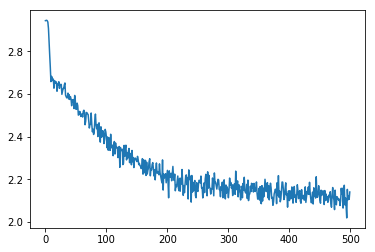

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.plot(all_losses)
plt.show()

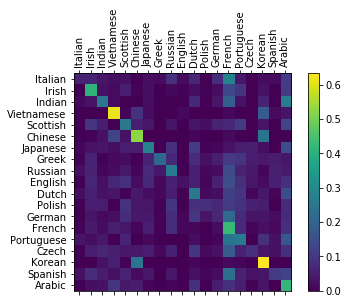

In [19]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
for i in range(n_categories):
    confusion[i] = confusion[i]/confusion[i].sum()
    
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()